## IN3050 Mandatory Assignment 2, 2025: Supervised Learning

## Dmitrii Soltaganov
### dmitriis@uio.no

### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn # This is only to generate a dataset

## Datasets

We start by making a synthetic dataset of 5000 instances and ten classes, with 500 instances in each class. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html regarding how the data are generated.) We choose to use a synthetic dataset---and not a set of natural occuring data---because we are mostly interested in properties of the various learning algorithms, in particular the differences between linear classifiers and multi-layer neural networks together with the difference between binary and multi-class data. In addition, we would like a dataset with instances represented with only two numerical features, so that it is easy to visualize the data. It would be rather difficult (although not impossible) to find a real-world dataset of the same nature. Anyway, you surely can use the code in this assignment for training machine learning models on real-world datasets.

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training, on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by Scikit-Learn, but that will not be the case with real-world data) We should split the data so that we keep the alignment between X (features) and t (class labels), which may be achieved by shuffling the indices. We split into 60% for training, 20% for validation, and 20% for final testing. The set for final testing *must not be used* till the end of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments. This is done by the `random_state` argument and the `rng = np.random.RandomState(424242)`.

In [2]:
# Generating the dataset
from sklearn.datasets import make_blobs
X, t_multi = make_blobs(n_samples=[500, 500, 500, 500, 500, 500, 500, 500, 500, 500], centers=[[0,1],[4,2],[8,1],[2,0],[6,0],[3,-3],[4,-2],[0,5],[0,4],[-2,-2]], 
                  n_features=2, random_state=424242, cluster_std=[1.0, 2.0, 1.0, 0.5, 0.5, 3.0, 1.0, 0.5, 2.5, 2.5])

In [3]:
# Shuffling the dataset
indices = np.arange(X.shape[0])
rng = np.random.RandomState(424242)
rng.shuffle(indices)
indices[:10]

array([3560, 4674,   49, 1257,  661, 3066, 3834, 4792,  570, 3855])

In [4]:
# Splitting into train, dev and test
X_train = X[indices[:3000],:]
X_val = X[indices[3000:4000],:]
X_test = X[indices[4000:],:]
t_multi_train = t_multi[indices[:3000]]
t_multi_val = t_multi[indices[3000:4000]]
t_multi_test = t_multi[indices[4000:]]

Next, we will  make a second dataset with only two classes by merging the existing labels in (X,t), so that `0-5` become the new `0` and `6-9` become the new `1`. Let's call the new set (X, t2). This will be a binary set.
We now have two datasets:

- Binary set: `(X, t2)`
- Multi-class set: `(X, t_multi)`

In [5]:
t2_train = t_multi_train >= 6
t2_train = t2_train.astype("int")
t2_val = (t_multi_val >= 6).astype("int")
t2_test = (t_multi_test >= 6).astype("int")

We can plot the two traning sets.

Text(0.5, 1.0, 'Multi-class set')

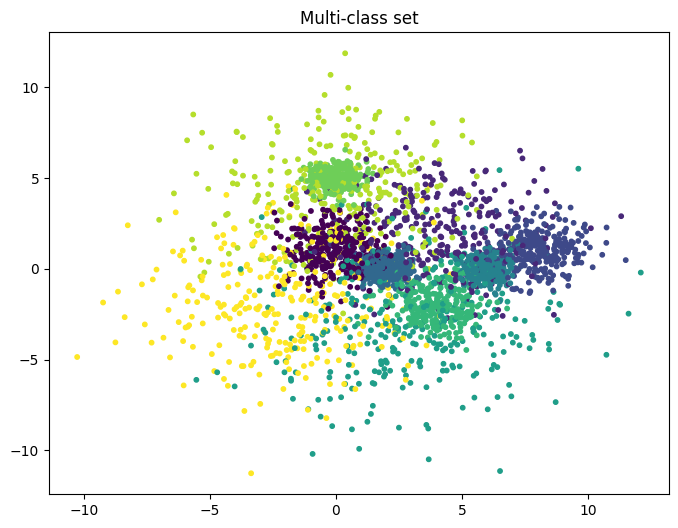

In [6]:
plt.figure(figsize=(8,6)) # You may adjust the size
plt.scatter(X_train[:, 0], X_train[:, 1], c=t_multi_train, s=10.0)
plt.title("Multi-class set")

Text(0.5, 1.0, 'Binary set')

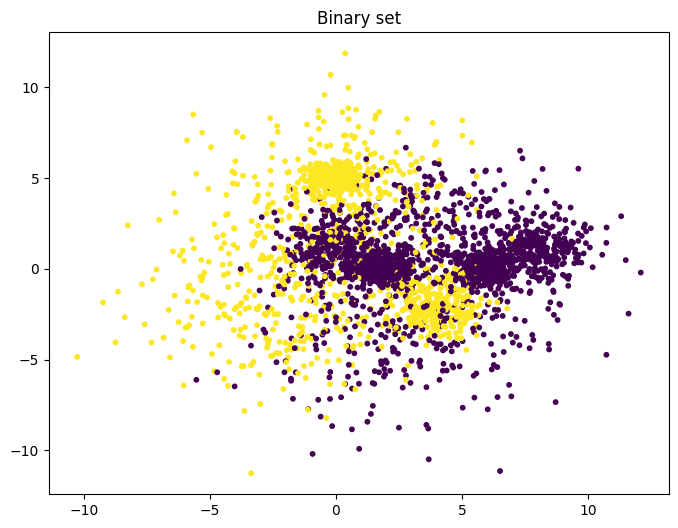

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=t2_train, s=10.0)
plt.title("Binary set")

# Part 1: Linear classifiers
### Linear regression

We see that even the binary set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression with the Mean Squared Error (MSE) loss, although it is not the most widely used approach for classification tasks: but we are interested. You may make your own implementation from scratch or start with the solution to the weekly exercise set 6. We include it here with a little added flexibility.

In [8]:
def add_bias(X, bias):
    """X is a NxM matrix: N datapoints, M features
    bias is a bias term, -1 or 1, or any other scalar. Use 0 for no bias
    Return a Nx(M+1) matrix with added bias in position zero
    """
    N = X.shape[0]
    biases = np.ones((N, 1)) * bias # Make a N*1 matrix of biases
    # Concatenate the column of biases in front of the columns of X.
    return np.concatenate((biases, X), axis  = 1) 

In [9]:
class NumpyClassifier():
    """Common methods to all Numpy classifiers --- if any"""

In [10]:
class NumpyLinRegClass(NumpyClassifier):

    def __init__(self, bias=-1):
        self.bias=bias
    
    def fit(self, X_train, t_train, lr = 0.1, epochs=10):
        """X_train is a NxM matrix, N data points, M features
        t_train is avector of length N,
        the target class values for the training data
        lr is our learning rate
        """
        
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            
        (N, M) = X_train.shape
        
        self.weights = weights = np.zeros(M)
        
        for epoch in range(epochs):
            # print("Epoch", epoch)
            weights -= lr / N *  X_train.T @ (X_train @ weights - t_train)      
    
    def predict(self, X, threshold=0.5):
        """X is a KxM matrix for some K>=1
        predict the value for each point in X"""
        if self.bias:
            X = add_bias(X, self.bias)
        ys = X @ self.weights
        return ys > threshold

We can train and test a first classifier (on the binary dataset).

In [11]:
def accuracy(predicted, gold):
    return np.mean(predicted == gold)

In [12]:
cl = NumpyLinRegClass()
cl.fit(X_train, t2_train, epochs=10)
accuracy(cl.predict(X_val), t2_val)

np.float64(0.638)

The following is a small procedure which plots the data set together with the decision boundaries. 
You may modify the colors and the rest of the graphics as you like.
The procedure will also work for multi-class classifiers

In [13]:
def plot_decision_regions(X, t, clf=[], size=(8,6), title="Decision regions"):
    """Plot the data set (X,t) together with the decision boundary of the classifier clf"""
    # The region of the plane to consider determined by X
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Make a prediction of the whole region
    h = 0.02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Classify each meshpoint.
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=size) # You may adjust this

    # Put the result into a color plot
    plt.contourf(xx, yy, Z, alpha=0.2, cmap = 'tab10')

    plt.scatter(X[:,0], X[:,1], c=t, s=10.0, cmap='tab10')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.xlabel("x0")
    plt.ylabel("x1")

#    plt.show()

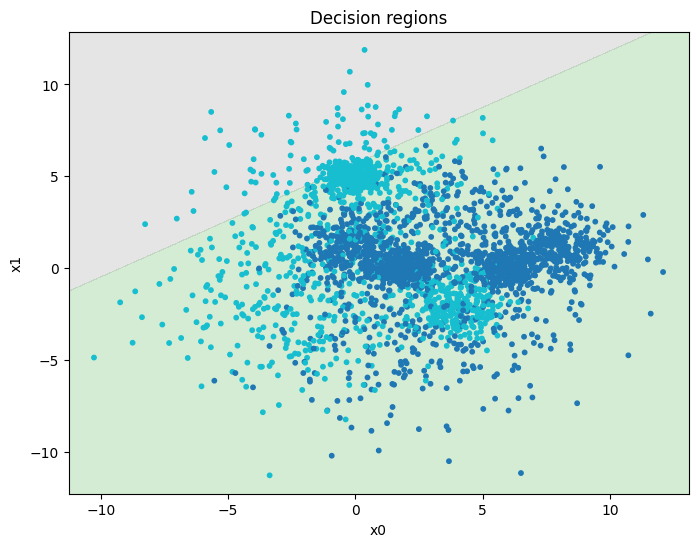

In [14]:
plot_decision_regions(X_train, t2_train, cl)

### Task: Tuning

The result is far from impressive. 
Remember that a classifier which always chooses the majority class will have an accuracy of 0.6 on this data set.

Your task is to try various settings for the two training hyper-parameters, learning rate and the number of epochs, to get the best accuracy on the validation set. 

Report how the accuracy varies with the hyper-parameter settings. It it not sufficient to give the final hyperparameters. You must also show how you found then and results for alternative values you tried aout.

When you are satisfied with the result, you may plot the decision boundaries, as above.

BEST: lr=0.1, epochs=50, accuracy=0.7610
Time: 0.13 seconds


,lr (unscaled),acc (unscaled),epochs
0,0.001,5,0.597
1,0.001,10,0.597
2,0.001,50,0.597
3,0.001,100,0.597
4,0.010,5,0.597
5,0.010,10,0.597
6,0.010,50,0.612
7,0.010,100,0.634
8,0.100,5,0.612
9,0.100,10,0.638


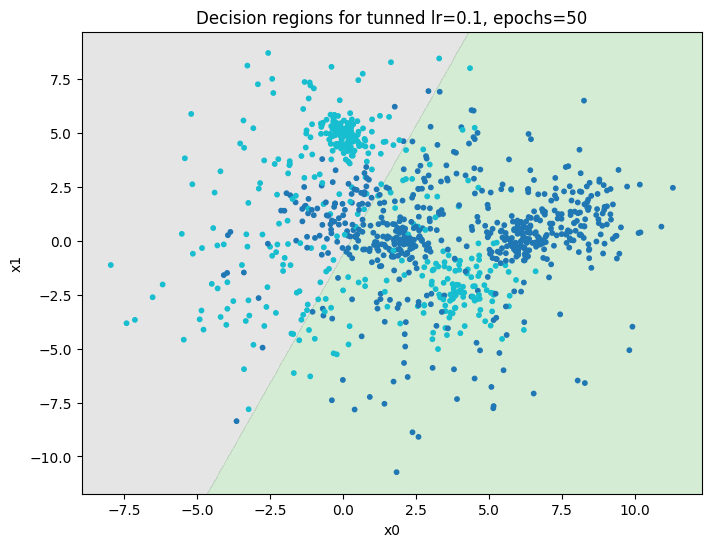

In [15]:
# I report the accuracy change in the table below 

#Scaling the data
import pandas as pd 
# Tuning the parameters
import time
learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]
epoch_values = [5, 10, 50, 100]
results = []

for lr in learning_rates:
    for epochs in epoch_values:
        clf = NumpyLinRegClass()
        clf.fit(X_train, t2_train, lr=lr, epochs=epochs)
        acc = accuracy(clf.predict(X_val), t2_val)
        results.append((lr, epochs, acc))

best_acc = 0
best_lr = 0
best_epochs = 0
for lr, epochs, acc in results:
    if acc > best_acc:
        best_acc = acc
        best_lr = lr
        best_epochs = epochs
        
print(f"BEST: lr={best_lr}, epochs={best_epochs}, accuracy={best_acc:.4f}")
time_start = time.time()
best_clf = NumpyLinRegClass()
best_clf.fit(X_train, t2_train, best_lr, best_epochs)
plot_decision_regions(X_val, t2_val, best_clf,title=f"Decision regions for tunned lr={best_lr}, epochs={best_epochs}")
time_stop = time.time()
print(f"Time: {time_stop - time_start:.2f} seconds")

# Collect the comparison results
comparison_data = []

for i in range(len(results)):
    lr, acc, n_ep = results[i]
    comparison_data.append({
        'lr (unscaled)': lr,
        'acc (unscaled)': round(acc, 4),
        'epochs': n_ep,
    })

# Create and display DataFrame
df_comparison = pd.DataFrame(comparison_data)
pd.set_option('display.max_rows', None)  # Show all rows
display(df_comparison)

### Task: Scaling

We have seen in the lectures that scaling the data may improve training speed and sometimes the performance. 

- Implement the standard scaler (normalizer); you can also try other scaling techniques
- Scale the data
- Train the model on the scaled data
- Experiment with hyper-parameter settings and see whether you can speed  up or improve the training.
- Report final hyper-parameter settings and show how you found them.

BEST: lr=0.5, epochs=5, accuracy=0.7580
Time: 0.04 seconds


,lr (unscaled),epochs (unscaled),acc (unscaled),lr (scaled),epochs (scaled),acc (scaled)
0,0.001,5,0.597,0.001,5,0.597
1,0.001,10,0.597,0.001,10,0.597
2,0.001,50,0.597,0.001,50,0.597
3,0.001,100,0.597,0.001,100,0.597
4,0.010,5,0.597,0.010,5,0.597
5,0.010,10,0.597,0.010,10,0.597
6,0.010,50,0.612,0.010,50,0.597
7,0.010,100,0.634,0.010,100,0.633
8,0.100,5,0.612,0.100,5,0.597
9,0.100,10,0.638,0.100,10,0.640


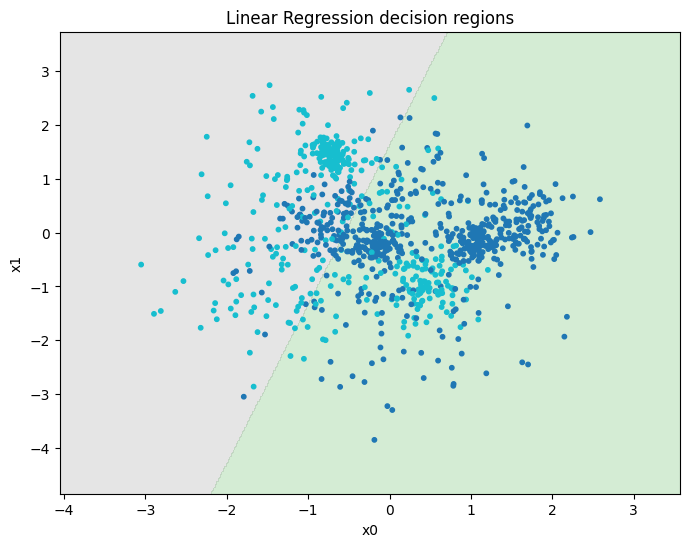

In [16]:
# Model works significantly faster on the scaled data, but
# it becomes less accurate
# See table below for comparassion of acaled and unscaled data

#Scaling the data
def standard_scale(X_train, X_val):
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    # Avoid division by zero
    std[std == 0] = 1
    
    X_train_scaled = (X_train - mean) / std
    X_val_scaled = (X_val - mean) / std
    return X_train_scaled, X_val_scaled

X_train_scaled, X_val_scaled = standard_scale(X_train, X_val)

results_scaled = []
def run_lin_reg_tuning(X_train, X_val, t_train, t_val, learning_rates, epoch_values, title="Decision regions", ploting=True):

    results_scaled = []

    # Grid search over learning rates and epochs
    for lr in learning_rates:
        for epochs in epoch_values:
            clf = NumpyLinRegClass()
            clf.fit(X_train, t_train, lr=lr, epochs=epochs)
            acc = accuracy(clf.predict(X_val), t_val)
            results_scaled.append((lr, epochs, acc))

    # Select best hyperparameters
    best_result = max(results_scaled, key=lambda x: x[2])
    best_lr_scaled, best_epochs_scaled, best_acc_scaled = best_result

    if ploting:
        print(f"BEST: lr={best_lr_scaled}, epochs={best_epochs_scaled}, accuracy={best_acc_scaled:.4f}")

    # Train best model
    time_start = time.time()
    best_clf_scaled = NumpyLinRegClass()
    best_clf_scaled.fit(X_train, t_train, best_lr_scaled, best_epochs_scaled)
    if ploting:
        plot_decision_regions(X_val, t_val, best_clf_scaled,
                          title=title)
    time_stop = time.time()
    if ploting:
        print(f"Time: {time_stop - time_start:.2f} seconds")

    return best_clf_scaled, best_result, results_scaled

learning_rates = [0.001, 0.01, 0.1, 0.5, 1]
epoch_values = [5, 10, 50, 100]

best_clf, best_result, results_scaled = run_lin_reg_tuning(
    X_train_scaled, X_val_scaled, t2_train, t2_val, learning_rates, epoch_values, 
    title="Linear Regression decision regions"
)

# Collect the comparison results
comparison_data = []

for i in range(len(results_scaled)):
    lr, epochs, acc = results[i]
    lr_scaled, epochs_scaled, acc_scaled = results_scaled[i]
    comparison_data.append({
        'lr (unscaled)': lr,
        'epochs (unscaled)': epochs,
        'acc (unscaled)': round(acc, 4),
        'lr (scaled)': lr_scaled,
        'epochs (scaled)': epochs_scaled,
        'acc (scaled)': round(acc_scaled, 4)
    })

# Create and display DataFrame
df_comparison = pd.DataFrame(comparison_data)
pd.set_option('display.max_rows', None)  # Show all rows
display(df_comparison)

## Logistic regression
a) You should now implement a logistic regression classifier similarly to the classifier based on linear regression.
You may use the code from the solution to weekly exercise set week06.


b) In addition to the method `predict()` which predicts a class for the data, include a method `predict_probabilities()` which predicts the probability of the data belonging to the positive class.



c) So far, we have not calculated the loss explicitly in the code. Extend the code to calculate the loss on the training set for each epoch and to store the losses such that the losses can be inspected after training. The prefered loss for logistic regression is binary cross-entropy, but you can also try mean squared error. The most important is that your implementation of the loss corresponds to your implementation of the gradient descent.
Also, calculate and store accuracies after each epoch.



d) In addition, extend the `fit()` method with optional arguments for a validation set (X_val, t_val). If a validation set is included in the call to `fit()`, calculate the loss and the accuracy for the validation set after each epoch. 



e) The training runs for a number of epochs. We cannot know beforehand for how many epochs it is reasonable to run the training. One possibility is to run the training until the learning does not improve much. Extend the `fit()` method with two keyword arguments, `tol` (tolerance) and `n_epochs_no_update` and stop training when the loss has not improved with more than `tol` after `n_epochs_no_update` (to save compute and potentially avoid over-fitting). A possible default value for `n_epochs_no_update` is 2. Also, add an attribute to the classifier which tells us after fitting how many epochs it was trained for.


In [17]:
# I use code from week06

def logistic(x):
    return 1 / (1 + np.exp(-x))
#a)
class NumpyLogReg:
    def __init__(self, bias=-1):
        self.bias = bias
        self.weights = None
        #c)
        self.losses = []
        self.accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.n_epochs_trained = 0

    def forward(self, X):
        return logistic(X @ self.weights)

    def predict(self, X, threshold=0.5):
        if self.bias:
            X = add_bias(X, self.bias)
        return (self.forward(X) > threshold).astype(int)
    #b)
    def predict_probabilities(self, X):
        if self.bias:
            X = add_bias(X, self.bias)
        return self.forward(X)

    #d and e)
    def fit(self, X_train, t_train, lr=0.1, epochs=100, X_val=None, t_val=None, tol=0.005, n_epochs_no_update=2):
        if self.bias:
            X_train = add_bias(X_train, self.bias)
            if X_val is not None:
                X_val = add_bias(X_val, self.bias)

        N, M = X_train.shape
        self.weights = np.zeros(M)
        self.losses, self.accuracies = [], []
        self.val_losses, self.val_accuracies = [], []
        self.n_epochs_trained = 0

        best_loss = float('inf')
        epochs_without_improvement = 0

        for e in range(epochs):
            predictions = self.forward(X_train)
            self.weights -= lr / N * X_train.T @ (predictions - t_train)

            train_loss = binary_cross_entropy(t_train, predictions)
            # train_loss = mean_squared_error(t_train, predictions)
            train_acc = accuracy((predictions > 0.5).astype(int), t_train)

            self.losses.append(train_loss)
            self.accuracies.append(train_acc)

            if X_val is not None and t_val is not None:
                val_pred = self.forward(X_val)
                val_loss = binary_cross_entropy(t_val, val_pred)
                # val_loss = mean_squared_error(t_val, val_pred)
                val_acc = accuracy((val_pred > 0.5).astype(int), t_val)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_acc)
                monitored_loss = val_loss
            else:
                monitored_loss = train_loss

            if best_loss - monitored_loss > tol:
                best_loss = monitored_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= n_epochs_no_update:
                break

        self.n_epochs_trained = e + 1

#c)        
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)
# GPT and me
def binary_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)  # prevent log(0)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))



f) Train classifiers with various learning rates, and with varying values for `tol` for finding the optimal values. Also consider the effect of scaling the data.


Running for unscaled data
lr=0.01, tol=1, accuracy=0.7710, epochs=5
Plotting decision regions


/var/folders/1n/l88sclxn1sq05mwzlscld9cr0000gn/T/ipykernel_47317/2166386175.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Time: 0.24 seconds
Running for scaled data
lr=24, tol=0.1, accuracy=0.7710, epochs=6
Plotting decision regions
Time: 0.05 seconds


,lr (unscaled),tol (unscaled),acc (unscaled),epochs,lr (scaled),tol (scaled),acc (scaled),epochs (scaled)
0,24.000,1.00,0.766,5,24.000,1.00,0.589,5
1,24.000,0.75,0.766,5,24.000,0.75,0.589,5
2,24.000,0.50,0.769,6,24.000,0.50,0.589,5
3,24.000,0.10,0.769,6,24.000,0.10,0.771,6
4,0.010,1.00,0.771,5,0.010,1.00,0.746,5
5,0.010,0.75,0.771,5,0.010,0.75,0.746,5
6,0.010,0.50,0.771,5,0.010,0.50,0.746,5
7,0.010,0.10,0.771,5,0.010,0.10,0.746,5
8,0.005,1.00,0.770,5,0.005,1.00,0.746,5
9,0.005,0.75,0.770,5,0.005,0.75,0.746,5


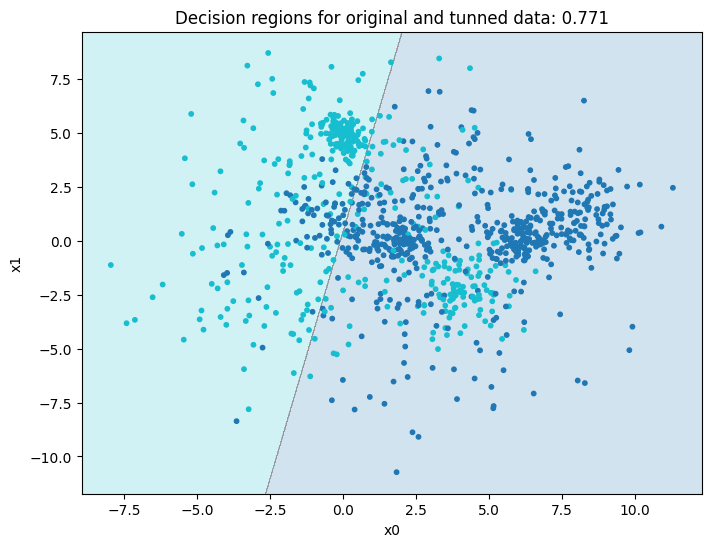

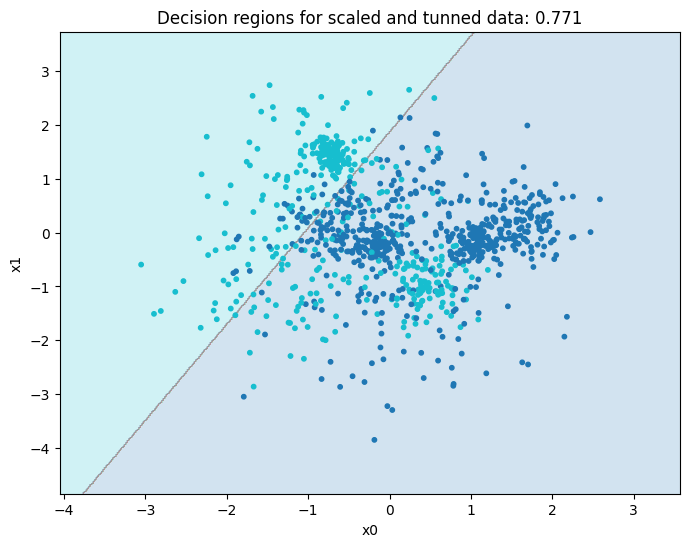

In [18]:
#See below for the table with comparision, scaled data show much better perfomance in runtime
# This code with scaled data works 3 times faster than on original data
# Still accuracy for original data is better, but win in perfomance is more significant which is essential for later exercises

X_train_scaled, X_val_scaled = standard_scale(X_train, X_val)

def run_log_reg_tuning_n(X_train, X_val, t_train, t_val, learning_rates, tolerances, epochs, n_epochs_no_update, title="Desicion regions",ploting=True):
    results = []

    for lr in learning_rates:
        for tol in tolerances:
            clf = NumpyLogReg()
            clf.fit(X_train, t_train, lr=lr, epochs=epochs, X_val=X_val, t_val=t_val, tol=tol, n_epochs_no_update=n_epochs_no_update)
            acc = accuracy(clf.predict(X_val), t_val)
            results.append((lr, tol, acc, clf.n_epochs_trained))

    best_result = max(results, key=lambda x: x[2])  # pick the one with the best accuracy
    best_lr, best_tol, best_acc, n_epochs = best_result

    if ploting:
        print(f"lr={best_lr}, tol={best_tol}, accuracy={best_acc:.4f}, epochs={n_epochs}")
    
    time_start = time.time()
    best_clf = NumpyLogReg()
    best_clf.fit(X_train, t_train, best_lr, epochs=epochs, X_val=X_val, t_val=t_val, tol=best_tol, n_epochs_no_update=n_epochs_no_update)

    if ploting:
        print("Plotting decision regions")
        plot_decision_regions(X_val, t_val, best_clf, title=title+": "+str(best_acc))
        
    time_stop = time.time()
    if ploting:
        print(f"Time: {time_stop - time_start:.2f} seconds")

    return best_clf, best_result, results


# Parameters
learning_rates = [24, 0.01, 0.005, 0.001]
tolerances = [1, 0.75, 0.5, 0.1]
epochs = 50
n_epochs_no_update = 4

# Unscaled
print("Running for unscaled data")
best_clf, best_result, results = run_log_reg_tuning_n(
    X_train, X_val, t2_train, t2_val,
    learning_rates, tolerances, epochs, n_epochs_no_update, title=f"Decision regions for original and tunned data"
)

# Scaled
print("Running for scaled data")
best_clf_scaled, best_result_scaled, results_scaled = run_log_reg_tuning_n(
    X_train_scaled, X_val_scaled, t2_train, t2_val,
    learning_rates, tolerances, epochs, n_epochs_no_update, title=f"Decision regions for scaled and tunned data"
)


# Collect the comparison results
comparison_data = []

for i in range(len(results_scaled)):
    lr, tol, acc, n_ep = results[i]
    lr_scaled, tol_scaled, acc_scaled, n_ep_scaled = results_scaled[i]
    comparison_data.append({
        'lr (unscaled)': lr,
        'tol (unscaled)': tol,
        'acc (unscaled)': round(acc, 4),
        'epochs': n_ep,
        'lr (scaled)': lr_scaled,
        'tol (scaled)': tol_scaled,
        'acc (scaled)': round(acc_scaled, 4),
        'epochs (scaled)': n_ep_scaled,
    })

# Create and display DataFrame
df_comparison = pd.DataFrame(comparison_data)
pd.set_option('display.max_rows', None)  # Show all rows
display(df_comparison)


g) After a succesful training, for your best model, plot both training loss and validation loss as functions of the number of epochs in one figure, and both training and validation accuracies as functions of the number of epochs in another figure. Comment on what you see. Are the curves monotone? Is this as expected?

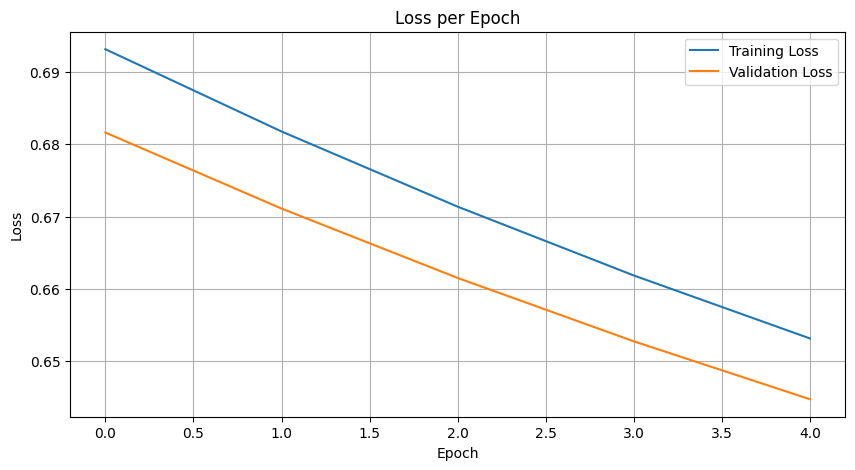

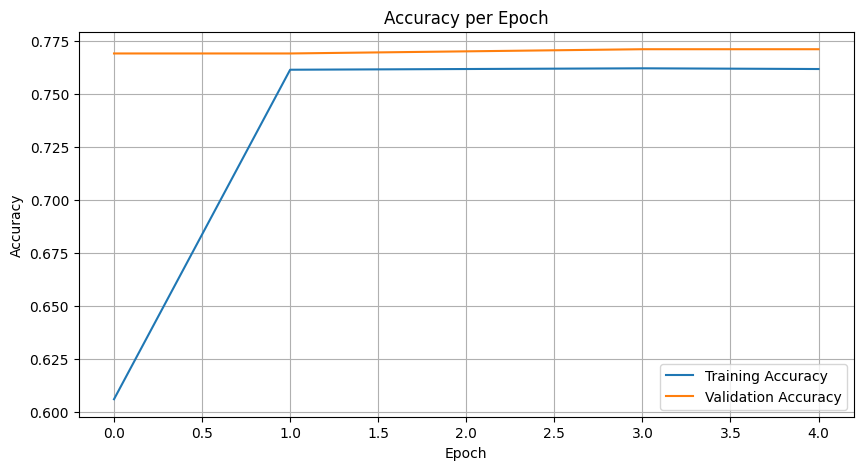

In [19]:
# Both training and validation loss decrease over epochs, which is expected as the model learns. 
# The accuracy curves also improve and flatten, suggesting that the model quickly reaches a good performance level. 
# The curves are monotonic, and no signs of overfitting are visible in the early epochs. 

plt.figure(figsize=(10, 5))
plt.plot(best_clf.losses, label='Training Loss')
plt.plot(best_clf.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(best_clf.accuracies, label='Training Accuracy')
plt.plot(best_clf.val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()


## Multi-class classifiers
We turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set `(X, t_multi)`.

### Multi-class with logistic regression
We saw in the lectures how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one logistic regression classifier for each class. To predict the class of an item, we run all the binary classifiers and collect the probability score from each of them. We assign the class which ascribes the highest probability.

Build such a classifier. Train the resulting classifier on `(X_train, t_multi_train)`, test it on `(X_val, t_multi_val)`, tune the hyper-parameters and report the accuracy.

Also plot the decision boundaries for your best classifier similarly to the plots for the binary case.

Running multi-class tuning on original data
Best multi-class model: lr=0.5, tol=0.01, accuracy=0.4510, epochs=32
Time: 0.75 seconds
Running multi-class tuning on scaled data
Best multi-class model: lr=0.01, tol=0.01, accuracy=0.6450, epochs=68
Time: 0.12 seconds


,lr (unscaled),tol (unscaled),acc (unscaled),lr (scaled),tol (scaled),acc (scaled)
0,0.005,0.40,0.303,0.005,0.40,0.344
1,0.005,0.30,0.303,0.005,0.30,0.344
2,0.005,0.20,0.303,0.005,0.20,0.344
3,0.005,0.10,0.303,0.005,0.10,0.344
4,0.005,0.05,0.306,0.005,0.05,0.344
5,0.005,0.01,0.305,0.005,0.01,0.344
6,0.010,0.40,0.305,0.010,0.40,0.344
7,0.010,0.30,0.305,0.010,0.30,0.344
8,0.010,0.20,0.305,0.010,0.20,0.344
9,0.010,0.10,0.312,0.010,0.10,0.344


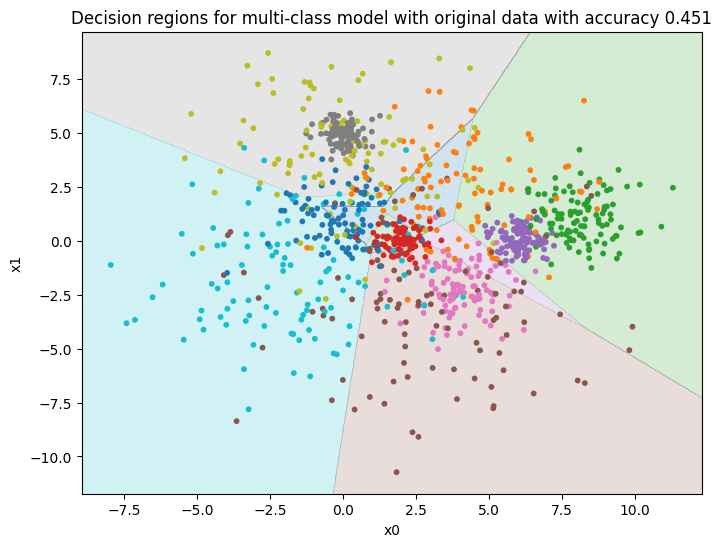

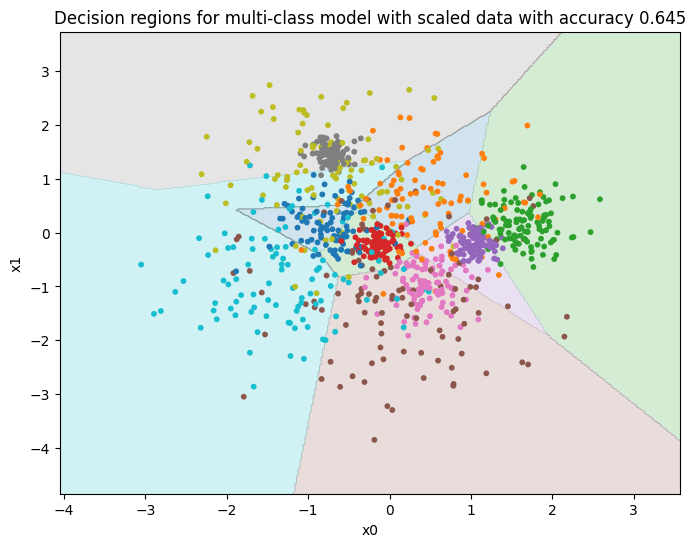

In [20]:
#IN3050 Multi-class classification
# I will also compare results of scaled data becouse here 
# it is finally more efficient and accurate results an on original data
# For comparisson see the table below

class OneVsRestLogReg:
    def __init__(self, lr=0.1, epochs=100, tol=0.005, n_epochs_no_update=2, bias=-1):
        self.lr = lr
        self.epochs = epochs
        self.tol = tol
        self.n_epochs_no_update = n_epochs_no_update
        self.bias = bias
        self.classifiers = []
        self.classes = []

    def fit(self, X_train, t_train, X_val=None, t_val=None):
        self.classes = np.unique(t_train)
        self.classifiers = []

        for c in self.classes:
            binary_target = (t_train == c).astype(int)
            val_target = (t_val == c).astype(int) if t_val is not None else None

            clf = NumpyLogReg(bias=self.bias) 
            clf.fit(
                X_train, binary_target,
                lr=self.lr, epochs=self.epochs,
                X_val=X_val, t_val=val_target,
                tol=self.tol, n_epochs_no_update=self.n_epochs_no_update
            )
            self.classifiers.append(clf)
    def predict(self, X):
        """Predicts the class with the highest probability"""
        prob_matrix = np.column_stack([
            clf.predict_probabilities(X) for clf in self.classifiers
        ])
        return np.argmax(prob_matrix, axis=1)


def run_multiclass_log_reg_tuning(X_train, X_val, t_train, t_val, learning_rates, tolerances, epochs, n_epochs_no_update, bias=-1, title="Decision regions"):
    
    results = []

    for lr in learning_rates:
        for tol in tolerances:
            clf = OneVsRestLogReg(
                lr=lr, epochs=epochs, tol=tol,
                n_epochs_no_update=n_epochs_no_update, bias=bias
            )
            clf.fit(X_train, t_train, X_val, t_val)
            acc = accuracy(clf.predict(X_val), t_val)
            results.append((lr, tol, acc, clf))

    best_lr, best_tol, best_acc, best_clf = max(results, key=lambda x: x[2])

    print(f"Best multi-class model: lr={best_lr}, tol={best_tol}, accuracy={best_acc:.4f}, epochs={best_clf.classifiers[0].n_epochs_trained}")

    time_start = time.time()
    plot_decision_regions(X_val, t_val, best_clf, title=title+" with accuracy "+str(best_acc))
    time_stop = time.time()

    print(f"Time: {time_stop - time_start:.2f} seconds")
    return best_clf, (best_lr, best_tol, best_acc), results

# Set hyperparameter ranges
learning_rates = [0.005, 0.01, 0.05, 0.1, 0.25, 0.5]
tolerances = [0.4, 0.3, 0.2, 0.1, 0.05, 0.01]
epochs = 100

# n_epochs_no_update = 5 #(0.6100)
n_epochs_no_update = 8 #(0.6450)
# n_epochs_no_update = 20 #(0.5790)


# Run tuning
print("Running multi-class tuning on original data")
best_multiclass_clf, best_result, results = run_multiclass_log_reg_tuning(
    X_train, X_val, t_multi_train, t_multi_val,
    learning_rates, tolerances, epochs, n_epochs_no_update, title="Decision regions for multi-class model with original data"
)

# Run scaled tuning
print("Running multi-class tuning on scaled data")
best_multiclass_clf, best_result, results_scaled = run_multiclass_log_reg_tuning(
    X_train_scaled, X_val_scaled, t_multi_train, t_multi_val,
    learning_rates, tolerances, epochs, n_epochs_no_update, title="Decision regions for multi-class model with scaled data"
)
# Collect the comparison results
comparison_data = []

for i in range(len(results_scaled)):
    lr, tol, acc, n_ep = results[i]
    lr_scaled, tol_scaled, acc_scaled, n_ep_scaled = results_scaled[i]
    comparison_data.append({
        'lr (unscaled)': lr,
        'tol (unscaled)': tol,
        'acc (unscaled)': round(acc, 4),
        'lr (scaled)': lr_scaled,
        'tol (scaled)': tol_scaled,
        'acc (scaled)': round(acc_scaled, 4),
    })

# Create and display DataFrame
df_comparison = pd.DataFrame(comparison_data)
pd.set_option('display.max_rows', None)
display(df_comparison)

Our classifier is not ideal. But is it because all the 10 classes are equally diffucult to predict?
You should evaluate the multinomial model predictions for each class separately and report your findings.
Please also report whether there is any difference in this respect between the training and the validation sets.

In [21]:
# My comparisson is presented below in the table. 
# No, Not all classes are difficult to predict results very from 0.19 for class 8 (train) to 0.97 for class 2(val) which is signifficant

def per_class_accuracy(y_true, y_pred, classes=None):
    if classes is None:
        classes = np.unique(y_true)
    accs = {}
    for cls in classes:
        cls_idx = (y_true == cls)
        if np.sum(cls_idx) == 0:
            accs[cls] = None
        else:
            accs[cls] = accuracy(y_pred[cls_idx], y_true[cls_idx])
    return accs

ovr_clf = best_multiclass_clf
# Training predictions
train_preds = ovr_clf.predict(X_train_scaled)
train_accs = per_class_accuracy(t_multi_train, train_preds, ovr_clf.classes)

# Validation predictions
val_preds = ovr_clf.predict(X_val_scaled)
val_accs = per_class_accuracy(t_multi_val, val_preds, ovr_clf.classes)

df_report = pd.DataFrame({
    'Class': ovr_clf.classes,
    'Train Accuracy': [round(train_accs[c], 4) for c in ovr_clf.classes],
    'Validation Accuracy': [round(val_accs[c], 4) for c in ovr_clf.classes]
})

display(df_report)


,Class,Train Accuracy,Validation Accuracy
0,0,0.5243,0.4516
1,1,0.4597,0.5051
2,2,0.9313,0.9722
3,3,0.9713,0.9780
4,4,0.8907,0.8235
5,5,0.4868,0.5192
6,6,0.3196,0.3235
7,7,0.9728,0.9697
8,8,0.1894,0.2549
9,9,0.6588,0.6600


# Part 2 Multi-layer neural networks

## A first non-linear classifier

The following code is a simple implementation of a multi-layer perceptron or feed-forward neural network.
For now, it is quite restricted.
There is only one hidden layer with 6 neurons.
It can only handle binary classification.
In addition, it uses a simple final layer similar to the linear regression classifier above.
One way to look at it is what happens when we add a hidden layer to the linear regression classifier.

The MLP class below misses the implementation of the `forward()` function. Your first task is to implement it. 

Remember that in the forward pass, we "feed" the input to the model, the model processes it and produces the output. The function should make use of the logistic activation function and bias.

In [22]:
# First, we define the logistic function and its derivative:
def logistic(x):
    return 1/(1+np.exp(-x))

def logistic_diff(y):
    return y * (1 - y)

In [23]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self, bias=-1, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.bias = bias
        # Dimensionality of the hidden layer
        self.dim_hidden = dim_hidden
        
        self.activ = logistic
        
        self.activ_diff = logistic_diff
    
    def forward(self, X):
        hidden_outs = []
        outputs = []

        for i in range(X.shape[0]):
            hidden_raw = self.activ(X[i] @ self.weights1).reshape(1, -1)
            hidden_out = add_bias(hidden_raw, self.bias)
            hidden_outs.append(hidden_out.squeeze())
            output = self.activ(hidden_out @ self.weights2)
            outputs.append(output.squeeze())

        hidden_outs = np.array(hidden_outs)
        outputs = np.vstack(outputs)
        return hidden_outs, outputs

    
    def fit(self, X_train, t_train, lr=0.001, epochs = 100):
        """Initialize the weights. Train *epochs* many epochs.
        
        X_train is a NxM matrix, N data points, M features
        t_train is a vector of length N of targets values for the training data, 
        where the values are 0 or 1.
        lr is the learning rate
        """
        self.lr = lr
        
        # Turn t_train into a column vector, a N*1 matrix:
        T_train = t_train.reshape(-1,1)
            
        dim_in = X_train.shape[1] 
        dim_out = T_train.shape[1]
        
        # Initialize the weights
        self.weights1 = (np.random.rand(
            dim_in + 1, 
            self.dim_hidden) * 2 - 1)/np.sqrt(dim_in)
        self.weights2 = (np.random.rand(
            self.dim_hidden+1, 
            dim_out) * 2 - 1)/np.sqrt(self.dim_hidden)
        X_train_bias = add_bias(X_train, self.bias)
        
        for e in range(epochs):
            # One epoch
            # The forward step:
            hidden_outs, outputs = self.forward(X_train_bias)
            # The delta term on the output node:
            out_deltas = (outputs - T_train)
            # The delta terms at the output of the hidden layer:
            hiddenout_diffs = out_deltas @ self.weights2.T
            # The deltas at the input to the hidden layer:
            hiddenact_deltas = (hiddenout_diffs[:, 1:] * 
                                self.activ_diff(hidden_outs[:, 1:]))  

            # Update the weights:
            self.weights2 -= self.lr * hidden_outs.T @ out_deltas
            self.weights1 -= self.lr * X_train_bias.T @ hiddenact_deltas 
            
    
    def predict(self, X):
        """Predict the class for the members of X"""
        Z = add_bias(X, self.bias)
        forw = self.forward(Z)[1]
        score= forw[:, 0]
        return (score > 0.5)

When implemented, this model can be used to make a non-linear classifier for the set `(X, t2)`. Experiment with settings for learning rate and epochs and see how good results you can get. 
Report results for various settings. Be prepared to train for a long time (but you can control it via the number of epochs and hidden size). 

Plot the training set together with the decision regions as in Part I.

Running for scaled data
BEST: lr=0.005, epochs=50, accuracy=0.7610
Plotting decision regions
Time: 8.46 seconds


,lr (scaled),epochs (scaled),acc (scaled)
0,0.0100,10,0.622
1,0.0100,50,0.648
2,0.0050,10,0.410
3,0.0050,50,0.761
4,0.0010,10,0.751
5,0.0010,50,0.753
6,0.0008,10,0.602
7,0.0008,50,0.755
8,0.0005,10,0.604
9,0.0005,50,0.755


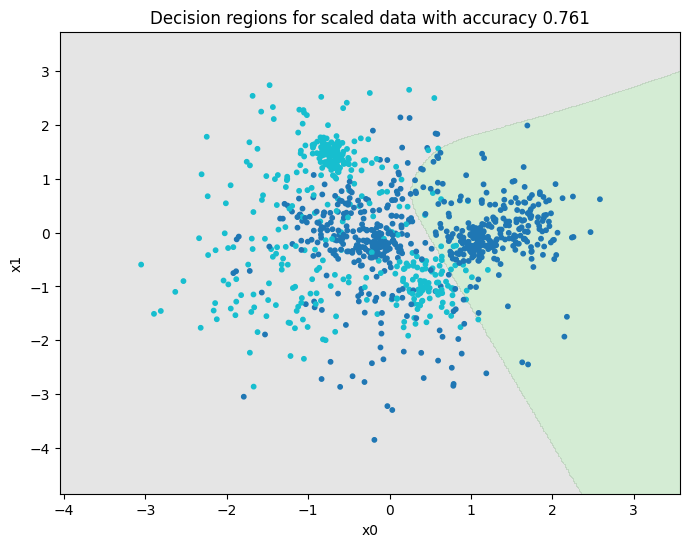

In [24]:
# See the comparison of parameters below in the table

def run_log_reg_tuning(X_train, X_val, t_train, t_val, learning_rates, epochs, title="Decision regions"):
    results = []

    for lr in learning_rates:
        for e in epochs:
            clf = MLPBinaryLinRegClass()
            clf.fit(X_train, t_train, lr=lr, epochs=e)
            acc = accuracy(clf.predict(X_val), t_val)
            results.append((lr, acc, e))

    best_result = max(results, key=lambda x: x[1])
    best_lr, best_acc, n_epochs = best_result

    print(f"BEST: lr={best_lr}, epochs={n_epochs}, accuracy={best_acc:.4f}")
    
    time_start = time.time()
    best_clf = MLPBinaryLinRegClass()
    best_clf.fit(X_train, t_train, best_lr, epochs=n_epochs)
    print("Plotting decision regions")
    plot_decision_regions(X_val, t_val, best_clf, title=title+" with accuracy "+str(best_acc))
    time_stop = time.time()
    print(f"Time: {time_stop - time_start:.2f} seconds")

    return best_clf, best_result, results


# Parameters
# learning_rates = [0.05, 0.01, 0.005, 0.001]
learning_rates = [0.01, 0.005, 0.001, 0.0008, 0.0005]

epochs = [10, 50]

# Scaled
print("Running for scaled data")
best_clf_scaled, best_result_scaled, results_scaled = run_log_reg_tuning(
    X_train_scaled, X_val_scaled, t2_train, t2_val,
    learning_rates, epochs, title="Decision regions for scaled data")


# Collect the comparison results
comparison_data = []

for i in range(len(results_scaled)):
    lr_scaled, acc_scaled, n_ep_scaled = results_scaled[i]
    comparison_data.append({
        'lr (scaled)': lr_scaled,
        'epochs (scaled)': n_ep_scaled,
        'acc (scaled)': round(acc_scaled, 4),
    })

# Create and display DataFrame
df_comparison = pd.DataFrame(comparison_data)
pd.set_option('display.max_rows', None)  # Show all rows
display(df_comparison)

# Improving the MLP classifier
You should now make changes to the classifier similarly to what you did with the logistic regression classifier in part 1.

a) In addition to the `predict()` method, which predicts a class for the data, include the `predict_probabilities()` method which predict the probability of the data belonging to the positive class. The training should be based on these values, as with logistic regression.

b) Calculate the loss and the accuracy after each epoch and store them for inspection after training.

c) Extend the `fit()` method with optional arguments for a validation set `(X_val, t_val)`. If a validation set is included in the call to `fit()`, calculate the loss and the accuracy for the validation set after each epoch.

d) Extend the `fit()` method with two keyword arguments, `tol` (tolerance) and `n_epochs_no_update` and stop training when the loss has not improved for more than `tol` after `n_epochs_no_update`. A possible default value for `n_epochs_no_update` is 2. Add an attribute to the classifier which tells us after fitting how many epochs it was trained on.

In [ ]:
class MLPBinaryLinRegClass(NumpyClassifier):
    """A multi-layer neural network with one hidden layer"""

    def __init__(self, bias=-1, dim_hidden=6):
        self.bias = bias
        # b)
        self.losses = []
        self.accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        self.n_epochs_trained = 0
        self.dim_hidden = dim_hidden
        self.activ = logistic
        self.activ_diff = logistic_diff

    def forward(self, X):
        
        hidden_outs = []
        outputs = []

        for i in range(X.shape[0]):
            hidden_raw = self.activ(X[i] @ self.weights1).reshape(1, -1)
            hidden_out = add_bias(hidden_raw, self.bias)
            hidden_outs.append(hidden_out.squeeze())
            output = self.activ(hidden_out @ self.weights2)
            outputs.append(output.squeeze())

        hidden_outs = np.array(hidden_outs)
        outputs = np.vstack(outputs)
        return hidden_outs, outputs

    # A) 
    def predict_probabilities(self, X):
        Z = add_bias(X, self.bias)
        _, outputs = self.forward(Z)
        return outputs[:, 0] 

    def predict(self, X):
        probabilities = self.predict_probabilities(X)
        return (probabilities > 0.5).astype(int)

    # c,d) Mostly done by ChatGPT 
    def fit(self, X_train, t_train, lr=0.001, epochs=100,
            X_val=None, t_val=None, tol=0.005, n_epochs_no_update=2):

        # b)
        self.lr = lr
        self.losses, self.accuracies = [], []
        self.val_losses, self.val_accuracies = [], []
        self.n_epochs_trained = 0

        T_train = t_train.reshape(-1, 1)
        dim_in = X_train.shape[1]
        dim_out = T_train.shape[1]

        self.weights1 = (np.random.rand(dim_in + 1, self.dim_hidden) * 2 - 1) / np.sqrt(dim_in)
        self.weights2 = (np.random.rand(self.dim_hidden + 1, dim_out) * 2 - 1) / np.sqrt(self.dim_hidden)

        X_train_bias = add_bias(X_train, self.bias)
        if X_val is not None:
            X_val_bias = add_bias(X_val, self.bias)
            T_val = t_val.reshape(-1, 1)

        best_loss = float("inf")
        epochs_without_improvement = 0

        for e in range(epochs):
            hidden_outs, outputs = self.forward(X_train_bias)

            # Backpropagation
            out_deltas = outputs - T_train
            hiddenout_diffs = out_deltas @ self.weights2.T
            hiddenact_deltas = hiddenout_diffs[:, 1:] * self.activ_diff(hidden_outs[:, 1:])

            self.weights2 -= self.lr * hidden_outs.T @ out_deltas
            self.weights1 -= self.lr * X_train_bias.T @ hiddenact_deltas

            # Use predict_probabilities for cleaner code
            train_probs = self.predict_probabilities(X_train)
            train_loss = binary_cross_entropy(t_train, train_probs)
            train_acc = accuracy((train_probs > 0.5).astype(int), t_train)
            self.losses.append(train_loss)
            self.accuracies.append(train_acc)

            if X_val is not None:
                val_probs = self.predict_probabilities(X_val)
                val_loss = binary_cross_entropy(t_val, val_probs)
                val_acc = accuracy((val_probs > 0.5).astype(int), t_val)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_acc)
                monitored_loss = val_loss
            else:
                monitored_loss = train_loss

            if best_loss - monitored_loss > tol:
                best_loss = monitored_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= n_epochs_no_update:
                break

        self.n_epochs_trained = e + 1


e) Tune the hyper-parameters: `lr`, `tol` and `dim-hidden` (size of the hidden layer).
Also, consider the effect of scaling the data.

g) The MLP algorithm contains an element of non-determinism. Hence, train the classifier 3 times with the optimal hyper-parameters and report the mean and standard deviation of the accuracies over the 3 runs.


Running 3 training runs with best hyperparameters for non-determinism check:

 Run NR: 0 Best MLP: lr=0.025, tol=0.01, hidden_dim=5, accuracy=0.7710, epochs=6
Time: 20.36 seconds

 Run NR: 0 Best MLP: lr=0.01, tol=0.05, hidden_dim=4, accuracy=0.7880, epochs=12
Time: 21.14 seconds

 Run NR: 0 Best MLP: lr=0.01, tol=0.05, hidden_dim=4, accuracy=0.7830, epochs=12
Time: 23.12 seconds

Mean accuracy over 3 runs: 0.7807
Standard deviation: 0.0071


,lr (scaled),tol (scaled),dim_hidden (scaled),acc (scaled),epochs (scaled)
0,0.025,0.05,4,0.403,11
1,0.025,0.05,5,0.403,9
2,0.025,0.01,4,0.597,9
3,0.025,0.01,5,0.643,14
4,0.010,0.05,4,0.788,12
5,0.010,0.05,5,0.770,13
6,0.010,0.01,4,0.455,6
7,0.010,0.01,5,0.403,14


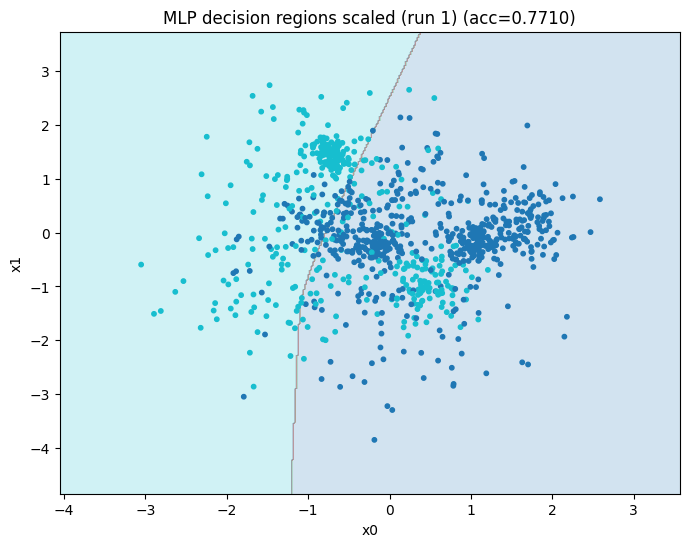

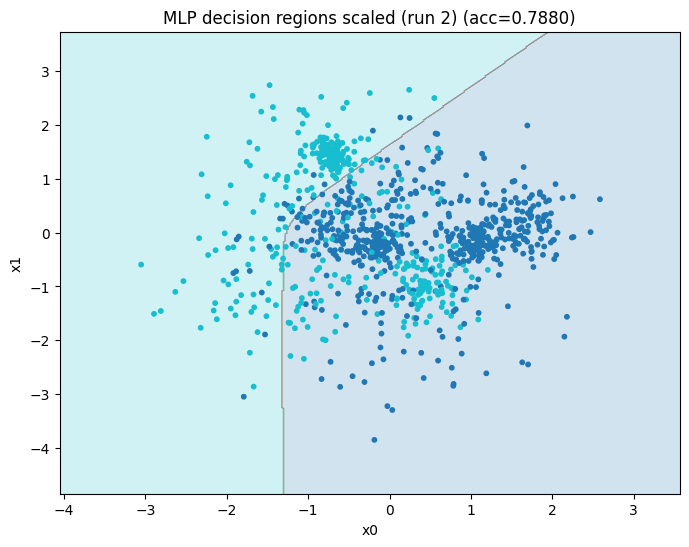

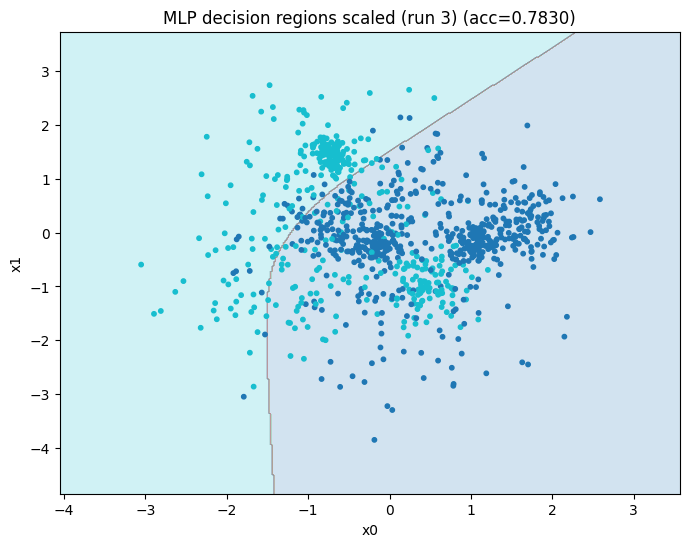

In [26]:
# I solve here tasks e) and g), task f) will be below

def run_mlp_binary_tuning(X_train, X_val, t_train, t_val,
                          learning_rates, tolerances, hidden_dims,
                          epochs, n_epochs_no_update, bias=-1,
                          title="Decision regions", run=0,ploting=True):
    results = []
    time_start = time.time()
    for lr in learning_rates:
        for tol in tolerances:
            for dim_hidden in hidden_dims:
                clf = MLPBinaryLinRegClass(bias=bias, dim_hidden=dim_hidden)
                clf.fit(X_train, t_train,
                        lr=lr, epochs=epochs,
                        X_val=X_val, t_val=t_val,
                        tol=tol, n_epochs_no_update=n_epochs_no_update)

                probs = clf.predict_probabilities(X_val)
                acc = accuracy((probs > 0.5).astype(int), t_val)
                results.append((lr, tol, dim_hidden, acc, clf.n_epochs_trained, clf))

    # Select best model
    best_lr, best_tol, best_dim, best_acc, best_epochs, best_clf = max(results, key=lambda x: x[3])

    if ploting:
        print(f"\n Run NR: {run} Best MLP: lr={best_lr}, tol={best_tol}, hidden_dim={best_dim}, "
              f"accuracy={best_acc:.4f}, epochs={best_epochs}")
        plot_decision_regions(X_val, t_val, best_clf,
                          title=title + f" (acc={best_acc:.4f})")
    time_stop = time.time()
    if ploting:
        print(f"Time: {time_stop - time_start:.2f} seconds")

    return best_clf, (best_lr, best_tol, best_dim, best_acc), results

# Evaluate the best model on multiple runs
def evaluate_best_mlp_multiple_runs(X_train, X_val, t2_train, t2_val,
    learning_rates, tolerances, hidden_dims,
    epochs, n_epochs_no_update, title="MLP decision regions unscaled", ploting=True):
    if ploting:
        print("\nRunning 3 training runs with best hyperparameters for non-determinism check:")

    accs = []
    epoch_counts = []

    best_run_acc = -1
    best_overall_clf = None
    best_overall_result = None
    best_overall_results_list = None

    for i in range(3):
        run_title = f"{title} (run {i+1})"
        best_clf, best_result, results = run_mlp_binary_tuning(
            X_train, X_val, t2_train, t2_val,
            learning_rates, tolerances, hidden_dims,
            epochs, n_epochs_no_update, title=run_title, ploting=ploting
        )

        best_lr, best_tol, best_dim, best_acc = best_result
        accs.append(best_acc)
        epoch_counts.append(best_clf.n_epochs_trained)

        # Save if best so far
        if best_acc > best_run_acc:
            best_run_acc = best_acc
            best_overall_clf = best_clf
            best_overall_result = best_result
            best_overall_results_list = results

    mean_acc = np.mean(accs)
    std_acc = np.std(accs)

    if ploting:
        print(f"\nMean accuracy over 3 runs: {mean_acc:.4f}")
        print(f"Standard deviation: {std_acc:.4f}")

    return accs, epoch_counts, mean_acc, std_acc, best_overall_clf, best_overall_result, best_overall_results_list

# learning_rates = [0.01, 0.05, 0.1]
learning_rates = [0.025, 0.01]
tolerances = [0.05, 0.01]
hidden_dims = [4, 5]
epochs = 100
n_epochs_no_update = 5

accs, epoch_counts, mean_acc, std_acc, best_clf_scaled, best_result_scaled, results_scaled = evaluate_best_mlp_multiple_runs(
    X_train_scaled, X_val_scaled, t2_train, t2_val,
    learning_rates, tolerances, hidden_dims,
    epochs, n_epochs_no_update, title="MLP decision regions scaled"
)


comparison_data = []
for i in range(len(results_scaled)):
    lr_s, tol_s, dim_s, acc_s, n_ep_s, _ = results_scaled[i]

    comparison_data.append({
        'lr (scaled)': lr_s,
        'tol (scaled)': tol_s,
        'dim_hidden (scaled)': dim_s,
        'acc (scaled)': round(acc_s, 4),
        'epochs (scaled)': n_ep_s,
    })

df_mlp_comparison = pd.DataFrame(comparison_data)
pd.set_option('display.max_rows', None)
display(df_mlp_comparison)

f) After a succesful training with the best setting for the hyper-parameters, plot both training loss and validation loss as functions of the number of epochs in one figure, and both training and validation accuracies as functions of the number of epochs in another figure. Comment on what you see.

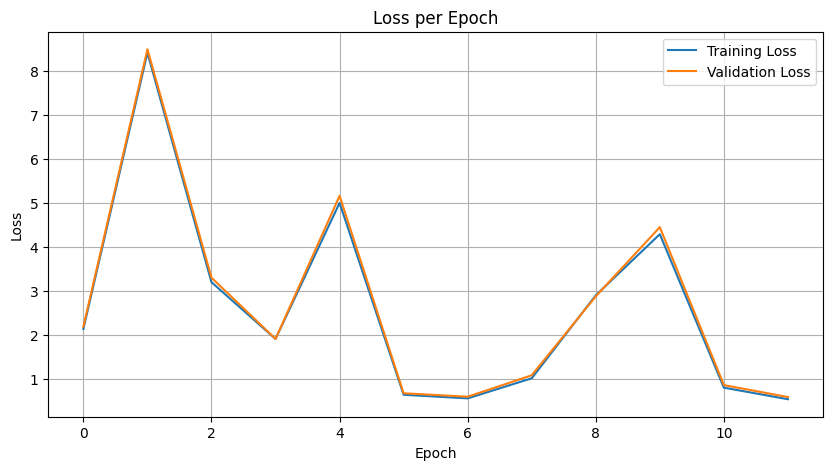

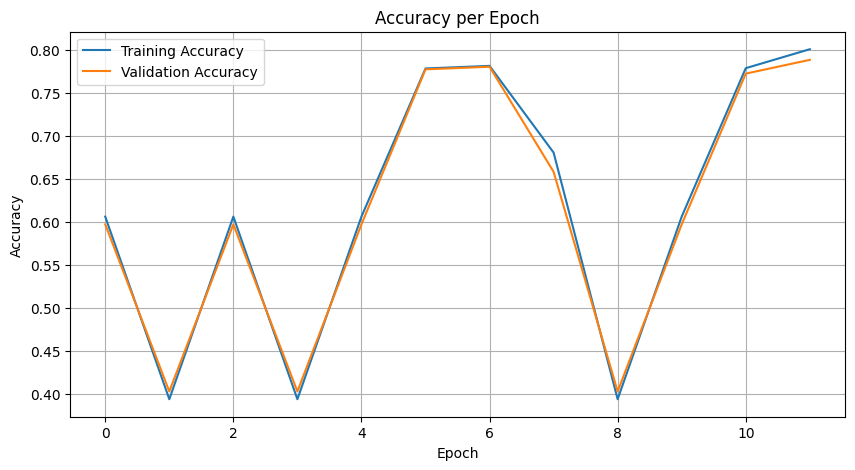

In [27]:
# This graphs are far from monotoncy.
# The loss and accuracy go up and down a lot instead of getting better over time. This is not expected. 
# It could mean that the learning rate is too high or that the training is unstable. 
# Normally, we want the loss to go down and the accuracy to go up more smoothly.

plt.figure(figsize=(10, 5))
plt.plot(best_clf_scaled.losses, label='Training Loss')
plt.plot(best_clf_scaled.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(best_clf_scaled.accuracies, label='Training Accuracy')
plt.plot(best_clf_scaled.val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Part III: Final testing
We can now perform a final testing on the held-out test set we created in the beginning.

## Binary task (X, t2)
Consider the linear regression classifier, the logistic regression classifier and the multi-layer network with the best settings you found. Train each of them on the training set and evaluate on the held-out test set, but also on the validation set and the training set. Report the performance in a 3 by 3 table.

Comment on what you see. How do the three different algorithms compare? Also, compare the results between the different dataset splits. In cases like these, one might expect slightly inferior results on the held-out test data compared to the validation and training data. Is this the case? 

Also report precision and recall for class 1.

In [28]:
# Results can very for MLP, but generally it performs on the level with Logistic regression (or can be slighter better or worse than LR)
#With MLP I could get results over 0.8 accuracy which is significantsdsds
# Logistic regression and MLP clearly outperform linear regression across all splits. 
# MLP achieves the best overall accuracy, especially on the test set. 
# However, the difference between MLP and LR is small, but LR is significantly faster and is more stable algoritm.
#Accuracy on the test set is slightly lower or comparable to validation, which is expected and indicates good generalization. 
# Overall, MLP performs best, but LR is a solid and simpler alternative.

#Example:
#                          Train	Validation	   Test
# Linear Regression	    Acc: 0.755	Acc: 0.758	Acc: 0.754
# Logistic Regression	Acc: 0.777	Acc: 0.771	Acc: 0.765
# MLP	                Acc: 0.802	Acc: 0.800	Acc: 0.790

# MLP had the best accuracy on all datasets. Logistic regression was close, and linear regression was a bit worse.
# Both MLP and logistic regression had high precision for class 1, meaning they were usually right when they predicted class 1. 
# But they had lower recall, so they missed many actual class 1 examples.
# Linear regression had more balanced precision and recall, but lower overall accuracy.
# The results look good — all models perform similarly on validation and test sets, so they generalize well.

# Precision and recall for class 1
# Linear Regression:    Precision = 0.749, Recall = 0.612
# Logistic Regression:  Precision = 0.888, Recall = 0.496
# MLP:                  Precision = 0.911, Recall = 0.516

X_train_scaled, X_val_scaled = standard_scale(X_train, X_val)
_, X_test_scaled = standard_scale(X_train, X_test)


# Linear Regression
lin_clf = NumpyLinRegClass()
lin_clf.fit(X_train_scaled, t2_train, lr=0.5, epochs=5)

# Logistic Regression
log_clf = NumpyLogReg()
log_clf.fit(X_train_scaled, t2_train, lr=24, epochs=50, 
            X_val=X_val_scaled, t_val=t2_val, tol=0.1, n_epochs_no_update=4)

# MLP
lr_mlp = [0.025]
tol_mlp = [0.05, 0.01]
h_dims_mlp = [4, 5]
e_mlp = 100
n_e_mlp = 5

# Run multiple times and get best trained MLP
_, _, _, _, mlp_clf, best_result_scaled, _ = evaluate_best_mlp_multiple_runs(
    X_train_scaled, X_val_scaled, t2_train, t2_val,
    lr_mlp, tol_mlp, h_dims_mlp, e_mlp, n_e_mlp, title="MLP decision regions scaled", ploting=False
)
def evaluate_model(model, X, y_true, is_numpy_linear=False):
    if is_numpy_linear:
        preds = (model.predict(X) > 0.5).astype(int)
    else:
        preds = model.predict(X)
    acc = accuracy(y_true, preds)
    return acc

results = {
    "Linear Regression": [
        evaluate_model(lin_clf, X_train_scaled, t2_train, is_numpy_linear=True),
        evaluate_model(lin_clf, X_val_scaled, t2_val, is_numpy_linear=True),
        evaluate_model(lin_clf, X_test_scaled, t2_test, is_numpy_linear=True),
    ],
    "Logistic Regression": [
        evaluate_model(log_clf, X_train_scaled, t2_train),
        evaluate_model(log_clf, X_val_scaled, t2_val),
        evaluate_model(log_clf, X_test_scaled, t2_test),
    ],
    "MLP": [
        evaluate_model(mlp_clf, X_train_scaled, t2_train),
        evaluate_model(mlp_clf, X_val_scaled, t2_val),
        evaluate_model(mlp_clf, X_test_scaled, t2_test),
    ]
}

df_results = pd.DataFrame.from_dict(results, orient='index', columns=["Train", "Validation", "Test"])
df_results = df_results.map(lambda x: f"Acc: {x:.3f}")

display(df_results)

# Precision metrics
def precision_recall_class_1(y_true, y_prob):
    y_pred = (y_prob > 0.5).astype(int)
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return precision, recall

# Linear Regression
lin_probs = lin_clf.predict(X_test_scaled)

# Logistic Regression
log_probs = log_clf.predict_probabilities(X_test_scaled)

# MLP
mlp_probs = mlp_clf.predict_probabilities(X_test_scaled)


# Evaluate
prec_lin, rec_lin = precision_recall_class_1(t2_test, lin_probs)
prec_log, rec_log = precision_recall_class_1(t2_test, log_probs)
prec_mlp, rec_mlp = precision_recall_class_1(t2_test, mlp_probs)

# Print
print("Precision & Recall for Class 1 (Test Set)")
print(f"Linear Regression:    Precision = {prec_lin:.3f}, Recall = {rec_lin:.3f}")
print(f"Logistic Regression:  Precision = {prec_log:.3f}, Recall = {rec_log:.3f}")
print(f"MLP:                  Precision = {prec_mlp:.3f}, Recall = {rec_mlp:.3f}")


,Train,Validation,Test
Linear Regression,Acc: 0.755,Acc: 0.758,Acc: 0.754
Logistic Regression,Acc: 0.777,Acc: 0.771,Acc: 0.765
MLP,Acc: 0.779,Acc: 0.787,Acc: 0.771


Precision & Recall for Class 1 (Test Set)
Linear Regression:    Precision = 0.749, Recall = 0.612
Logistic Regression:  Precision = 0.888, Recall = 0.496
MLP:                  Precision = 0.860, Recall = 0.535
